### Bias Threshold modification method

In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot') 
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import fair

In [7]:
train= pd.read_csv('Train_v2.csv')

In [8]:
#Load data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def load_data(data, s_attr):
    X= data.drop(['bank_account','uniqueid'],axis=1)
    Y= data['bank_account']
    Y=pd.Series([0 if x=='No' else 1 for x in Y])
    categorical_feature_mask = X.dtypes==object
    categorical_cols = X.columns[categorical_feature_mask].tolist()
    X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))
    Z = X.loc[:, s_attr]
#     X= X.drop([s_attr],axis=1)
    return X, Y, Z

In [9]:
X, Y, Z = load_data(train, 'gender_of_respondent')

In [10]:
# split data
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, Y, Z, 
                                                                     test_size=0.45,random_state=8) 
                                            

In [13]:
#This is a function that takes in the split data, sensitive attribute, unprotected group, classifier, classifier's threshold,
# and bias threshold and returns a fair prediction after the unfair classifier has trained on the 
# original data.
def PostProcessor(X_train, y_train,X_test,Z_test,y_test, sen_attr_col,unproc_attr_code, classifier, THRESHOLD, t):
    #The unfair classifier generate its prediction
    classifier.fit(X_train, y_train)
    pred_scores_init= classifier.predict_proba(X_test)[:,1]
    first_pred = np.where(pred_scores_init > THRESHOLD, 1, 0)
    #create an auxilliary dataset to alter
    plat = X_test.copy()
    plat['y_test_actual']=y_test
    plat['pred_scores_init']=pred_scores_init
    #splitting the auxilliary dataset to protected and unprotected groups
    proc_attr=plat.loc[plat[sen_attr_col] != unproc_attr_code]
    unproc_attr=plat.loc[plat[sen_attr_col] == unproc_attr_code] 
    #change unprotected group to protected group
    unproc_attr[sen_attr_col]=1
    faith= unproc_attr.copy()
    new_X_test=faith.drop(['y_test_actual','pred_scores_init'],axis=1)
    #generate prediction
    pred_scores_swap= classifier.predict_proba(new_X_test)[:,1]
    unproc_attr['pred_scores_swap']=pred_scores_swap
    # compute bias
    unproc_attr['bias']=np.abs(unproc_attr['pred_scores_init']-unproc_attr['pred_scores_swap'])
    proc_attr['finalpred']= np.where(proc_attr['pred_scores_init'] > THRESHOLD, 1, 0)
    # promote only thode who had favourable outcomes when in a different class
    up1=unproc_attr.loc[unproc_attr['bias'] < t]
    up1['finalpred']= np.where(up1['pred_scores_init'] > THRESHOLD, 1, 0)
    up=unproc_attr.loc[unproc_attr['bias'] >= t] 
    up['finalpred']= np.where(up['pred_scores_swap'] > THRESHOLD, 1, 0)
    #concatenate
    f=pd.concat([proc_attr,up])
    alll= pd.concat([f,up1])
    final_prediction=np.array(alll['finalpred'])
    return final_prediction

In [16]:
# All=[]
# models=[LogisticRegression(),GaussianNB(),
#         RandomForestClassifier(n_estimators=100,oob_score=True, random_state=12),
#         DecisionTreeClassifier(random_state = 21),MLPClassifier()]
# # models=[MLPClassifier(random_state = 21)]
# for model in models:
#     Df= []
#     for t in np.arange(0.1,1.0,0.1):
#         Result = PostProcessor(X_train, y_train,X_test,Z_test,y_test, 'gender_of_respondent',0, model, 0.5, t)
#         Df.append(Result)
#     All.append(Df)

In [15]:
#compute fairness metric values across classifiers
HH=[]
models=[LogisticRegression(),GaussianNB(),
        RandomForestClassifier(n_estimators=100,oob_score=True, random_state=12),
        DecisionTreeClassifier(random_state = 21),MLPClassifier()]
for model in models:
    Result = PostProcessor(X_train, y_train,X_test,Z_test,y_test, 'gender_of_respondent',0, model, 0.5, 0.3)
    D= fair.Get_fair_metric(model,Result,y_test,Z_test)
    HH.append(D)

In [17]:
#create dataframe
G=pd.DataFrame(HH).T

In [18]:
#visualize
G

,0,1,2,3,4
model,"LogisticRegression(C=1.0, class_weight=None, d...","GaussianNB(priors=None, var_smoothing=1e-09)","(DecisionTreeClassifier(ccp_alpha=0.0, class_w...","DecisionTreeClassifier(ccp_alpha=0.0, class_we...","MLPClassifier(activation='relu', alpha=0.0001,..."
Demographic Parity,0.0054046,0.00623639,0.00355603,0.0031146,0.00723502
Disparate Impact,0.792388,0.736538,0.735974,0.723829,0.872449
Equalised_opportunity,-0.00178748,-0.0118516,-0.00646203,-0.00892117,-0.00395955
Equalised_odds,-0.00638443,-0.00569507,-0.0032851,-0.00470579,-0.00815708
Treatment equality,0.569789,0.524764,0.520902,0.520112,0.63138
Predictive equality,0.00638443,0.00569507,0.0032851,0.00470579,0.00815708
Conditional Use Accuracy,0.0155851,-0.00365672,-0.00292844,0.00718287,0.01884
Overall Use Accuracy,0.00459695,-0.00615649,-0.00317692,-0.00421538,0.00419753
ROC Accuracy,0.49868,0.498484,0.499198,0.487575,0.498834


In [28]:
a=pd.DataFrame(All[0])
b= pd.DataFrame(All[1])
c= pd.DataFrame(All[2])
d= pd.DataFrame(All[3])
e= pd.DataFrame(All[4])

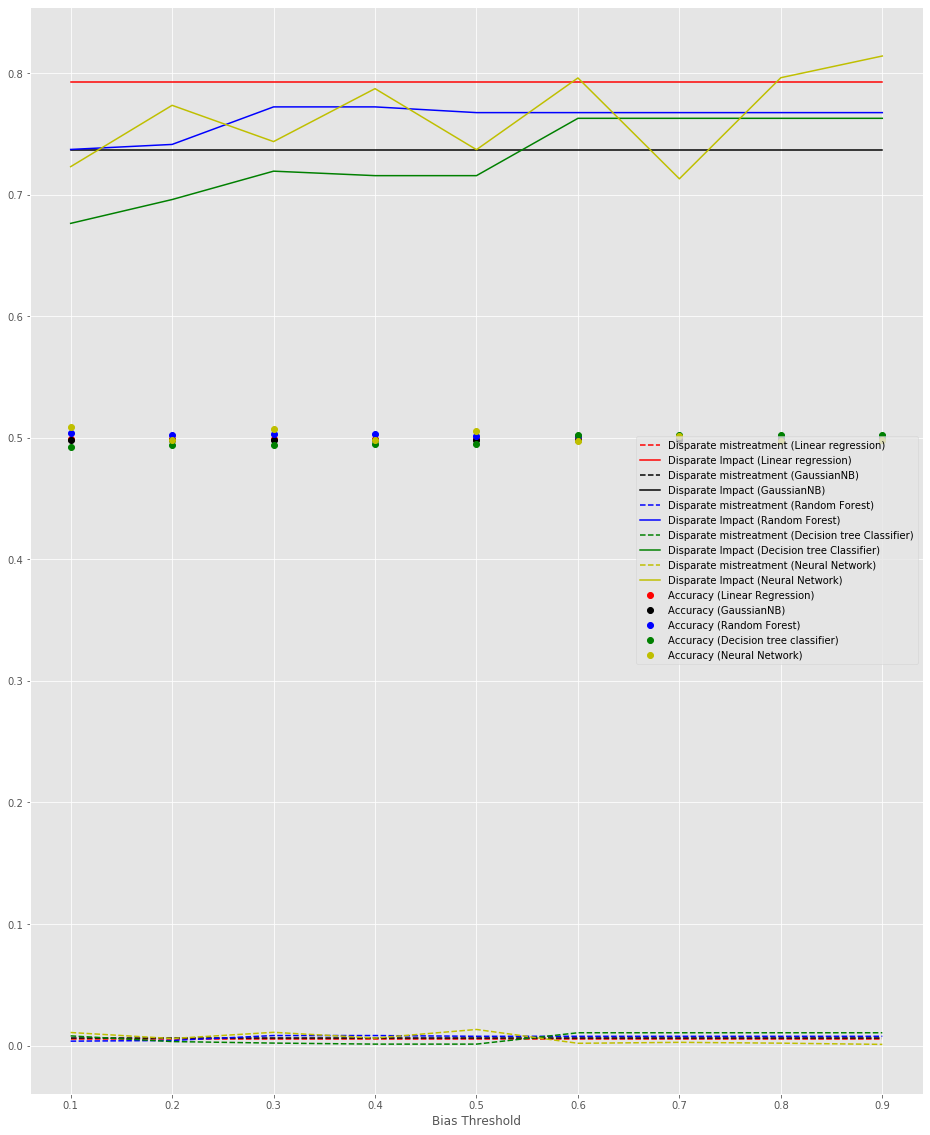

In [30]:
plt.figure(figsize=[16,20])
plt.plot(a['t'],a['modified_Disparate_mistreatment'],'--r',label='Disparate mistreatment (Linear regression)')
plt.plot(a['t'],a['modified_Disparate_Impact(prule)'],'r',label='Disparate Impact (Linear regression)')
plt.plot(b['t'],b['modified_Disparate_mistreatment'],'--k',label='Disparate mistreatment (GaussianNB)')
plt.plot(b['t'],b['modified_Disparate_Impact(prule)'],'k',label='Disparate Impact (GaussianNB)')

plt.plot(c['t'],c['modified_Disparate_mistreatment'],'--b',label='Disparate mistreatment (Random Forest)')
plt.plot(c['t'],c['modified_Disparate_Impact(prule)'],'b',label='Disparate Impact (Random Forest)')
plt.plot(d['t'],d['modified_Disparate_mistreatment'],'--g',label='Disparate mistreatment (Decision tree Classifier)')
plt.plot(d['t'],d['modified_Disparate_Impact(prule)'],'g',label='Disparate Impact (Decision tree Classifier)')
plt.plot(e['t'],e['modified_Disparate_mistreatment'],'--y',label='Disparate mistreatment (Neural Network)')
plt.plot(e['t'],e['modified_Disparate_Impact(prule)'],'y',label='Disparate Impact (Neural Network)')


plt.plot(a['t'],a['ROC_accuracy2'],'or',label='Accuracy (Linear Regression)')
plt.plot(b['t'],b['ROC_accuracy2'],'ok',label='Accuracy (GaussianNB)')
plt.plot(c['t'],c['ROC_accuracy2'],'ob',label='Accuracy (Random Forest)')
plt.plot(d['t'],d['ROC_accuracy2'],'og',label='Accuracy (Decision tree classifier)')
plt.plot(e['t'],e['ROC_accuracy2'],'oy',label='Accuracy (Neural Network)')
plt.xlabel('Bias Threshold')
plt.legend(loc=7)